In [80]:
import numpy as np
import pandas as pd

import re
import os
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

import nltk
import spacy

from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load spaCy's GloVe medium model
nlp = spacy.load("en_core_web_md")

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KARIM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KARIM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KARIM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
## Readind using pandas
df = pd.read_csv(r"C:\Users\KARIM\Downloads\Twitter-sentimental-analysis\data\testdata.manual.2009.csv", 
                encoding='ISO-8859-1', names=['target', 'id', 'date', 'flags', 'user', 'text'])
df.head()

,target,id,date,flags,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [12]:
df.shape

(498, 6)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  498 non-null    int64 
 1   id      498 non-null    int64 
 2   date    498 non-null    object
 3   flags   498 non-null    object
 4   user    498 non-null    object
 5   text    498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [14]:
df.describe()

,target,id
count,498.000000,498.000000
mean,2.020080,1867.226908
std,1.699686,2834.891681
min,0.000000,3.000000
25%,0.000000,388.250000
50%,2.000000,1013.500000
75%,4.000000,2366.750000
max,4.000000,14076.000000


## EDA

In [ ]:
df['target'].value_counts(normalize=True)  # 0: Negative, 2: Neutral, 4: Positive

4    0.365462
0    0.355422
2    0.279116
Name: target, dtype: float64

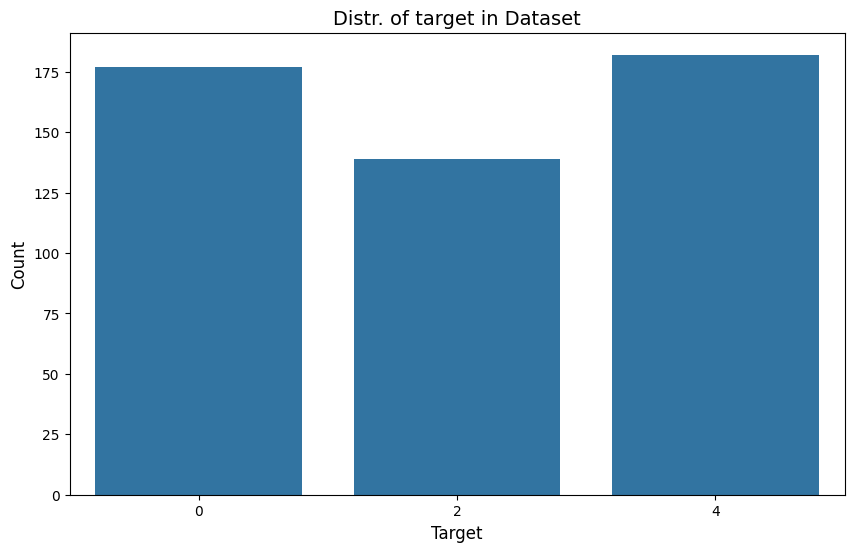

In [19]:
## countplot of target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='k')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [21]:
# take a deep copy from the DF
dataset = df[['target', 'text']]
dataset.head()

,target,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


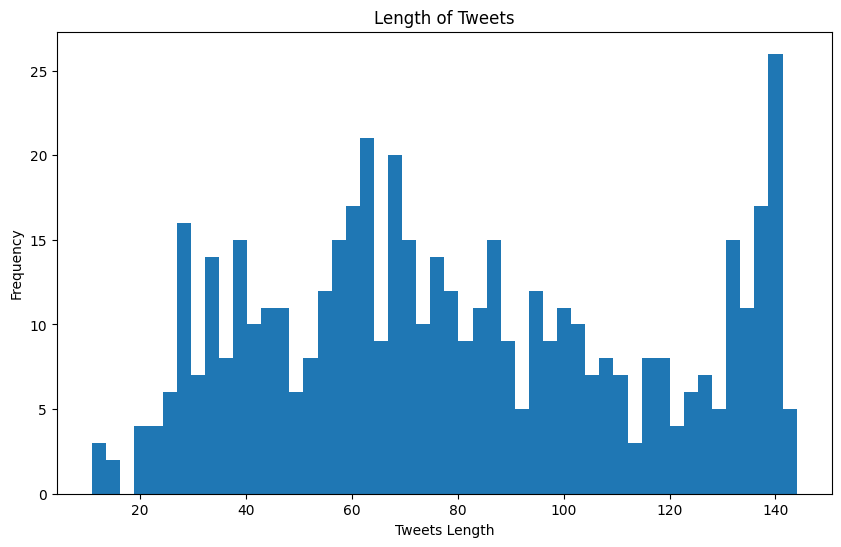

In [23]:
length_tweets = dataset['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(length_tweets, bins=50)
plt.title('Length of Tweets')
plt.xlabel('Tweets Length')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Hashtags
def hashtag_extract(x):
    hashtags = []
    ## Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags


# Extracting hashtags for each class
hash_neg = hashtag_extract(dataset[dataset['target']==0]['text'])  # Negative Hashtags
hash_neu = hashtag_extract(dataset[dataset['target']==2]['text'])  # Neutral Hashtags
hash_pos = hashtag_extract(dataset[dataset['target']==4]['text'])  # Positive Hashtags

# Unnesting the lists
hash_neg = sum(hash_neg, [])
hash_pos = sum(hash_pos, [])
hash_neu = sum(hash_neu, [])

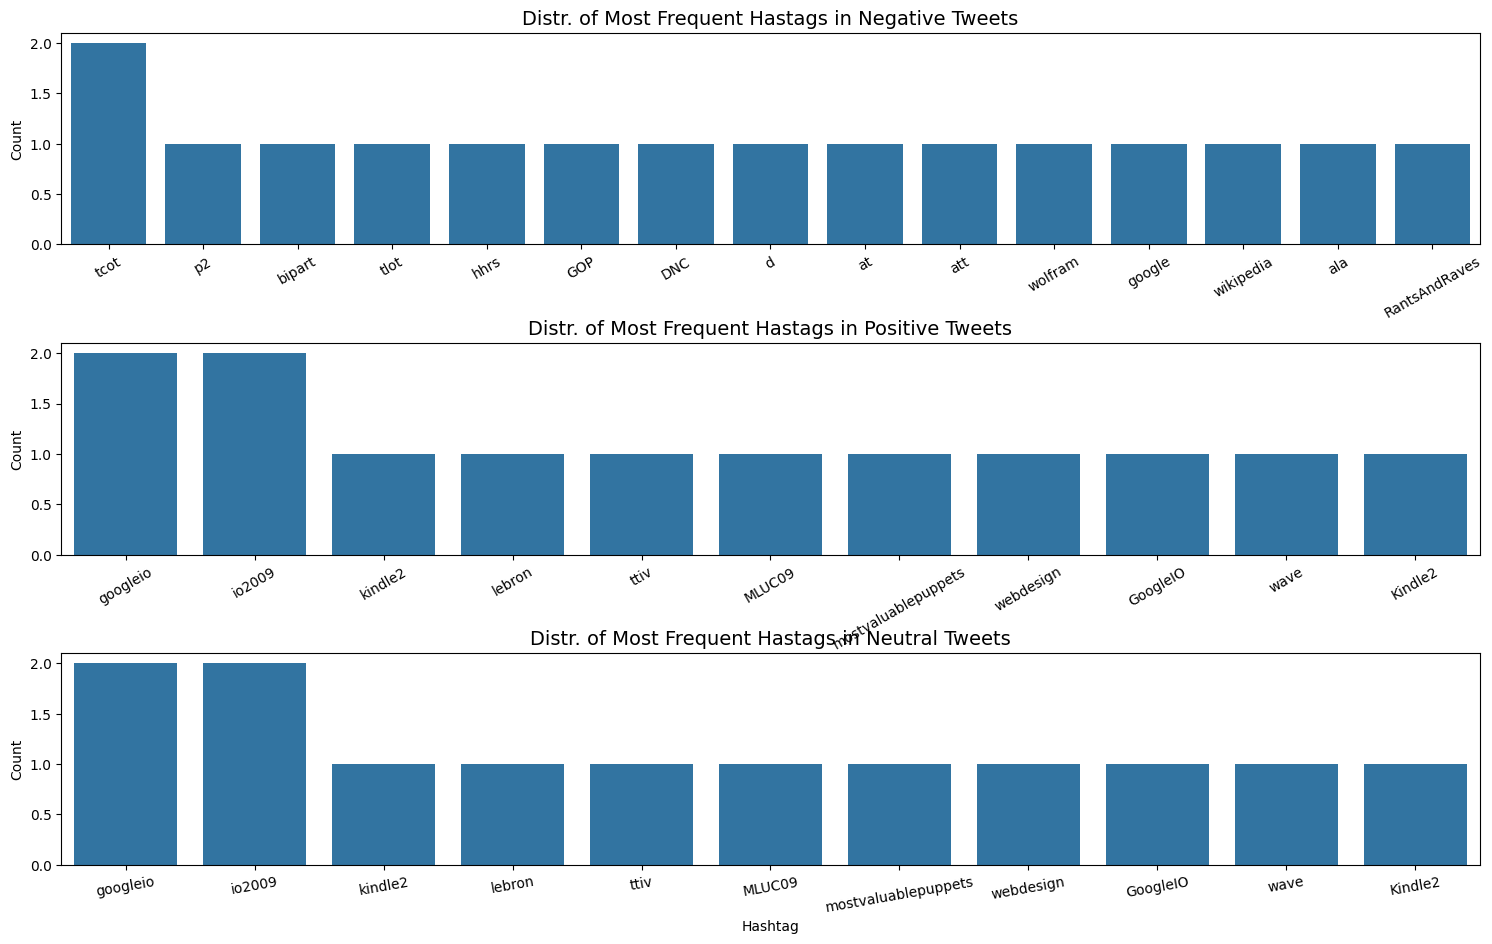

In [ ]:
a_neg = nltk.FreqDist(hash_neg)
a_neu = nltk.FreqDist(hash_neu)
a_pos = nltk.FreqDist(hash_pos)

# Negative Tweets
df_neg = pd.DataFrame({'Hashtag': list(a_neg.keys()),
                'Count': list(a_neg.values())})

# Positive Tweets
df_pos = pd.DataFrame({'Hashtag': list(a_pos.keys()),
                'Count': list(a_pos.values())})

# Neutral Tweets
df_neu = pd.DataFrame({'Hashtag': list(a_neu.keys()),
                'Count': list(a_neu.values())})

# selecting top 15 most frequent hashtags     
df_neg = df_neg.nlargest(columns='Count', n=15) 
df_pos = df_pos.nlargest(columns='Count', n=15) 
df_neu = df_pos.nlargest(columns='Count', n=15)


# Plotting
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
fig.tight_layout(pad=5)
plt.sca(ax[0])
sns.barplot(data=df_neg, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Negative Tweets', fontsize=14, c='k')
plt.xlabel('')

plt.sca(ax[1])
sns.barplot(data=df_pos, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Positive Tweets', fontsize=14, c='k')
plt.xlabel('')

plt.sca(ax[2])
sns.barplot(data=df_neu, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Neutral Tweets', fontsize=14, c='k')
plt.show()

# Clean Data

In [28]:
# Remove unwanted text patterns from the tweets
def remove_pattern(input_txt: str, pattern: str):
    ''' This Function takes the input and pattern you want to remove

    Args:
    *****
        (input_text: str) --> The text you want to apply the function to it.
        (pattern: str) --> The pattern you want to remove from the text.
    '''

    input_txt = re.sub(pattern, '', input_txt)
    return input_txt

In [50]:
# Removing @user in tweets, and apply the function
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: remove_pattern(x, r'@[\w]*'))
dataset.head()

,target,text
0,4,I loovvee my Kindle Not that the DX is cool...
1,4,Reading my kindle Love it Lee childs is ...
2,4,Ok first assesment of the #kindle it fucki...
3,4,You ll love your Kindle I ve had mine for a...
4,4,Fair enough But i have the Kindle and I th...


In [49]:
# Removing URL links in tweets, and apply the function
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: remove_pattern(x, r'https?://\S+|www\.\S+'))
dataset.head()

,target,text
0,4,I loovvee my Kindle Not that the DX is cool...
1,4,Reading my kindle Love it Lee childs is ...
2,4,Ok first assesment of the #kindle it fucki...
3,4,You ll love your Kindle I ve had mine for a...
4,4,Fair enough But i have the Kindle and I th...


In [48]:
# A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    # Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    # Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

# Apply the above function
dataset.loc[:, 'text'] = dataset['text'].apply(remove_excessive_repeated_characters)
dataset.head()

,target,text
0,4,I loovvee my Kindle Not that the DX is cool...
1,4,Reading my kindle Love it Lee childs is ...
2,4,Ok first assesment of the #kindle it fucki...
3,4,You ll love your Kindle I ve had mine for a...
4,4,Fair enough But i have the Kindle and I th...


In [47]:
# Emotions Mapping

# Convert Emojis to Text : example 😀 to Happy , 😢 Sad
# This Dataset doesn't contains emojis, but it contains emotioncons like that :D, :)
# So, We can't demojize, but we will map the moticons to its meaning.

emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}


# Function to replace emoticons with their meanings
def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead 
    '''
    for emoticon, meaning in emoticon_meanings.items():
        text = text.replace(emoticon, meaning)
    return text

# Apply the function on our dataset
dataset.loc[:, 'text'] = dataset['text'].apply(convert_emoticons)
dataset.head()

,target,text
0,4,I loovvee my Kindle Not that the DX is cool...
1,4,Reading my kindle Love it Lee childs is ...
2,4,Ok first assesment of the #kindle it fucki...
3,4,You ll love your Kindle I ve had mine for a...
4,4,Fair enough But i have the Kindle and I th...


In [46]:
# Remove Punctuatiosn, Numbers, Special Chars

# Removing Punctuations, Numbers, and Special Characters
dataset.loc[:, 'text'] = dataset['text'].str.replace('[^a-zA-Z#]', ' ', regex=True)
dataset.head()

,target,text
0,4,I loovvee my Kindle Not that the DX is cool...
1,4,Reading my kindle Love it Lee childs is ...
2,4,Ok first assesment of the #kindle it fucki...
3,4,You ll love your Kindle I ve had mine for a...
4,4,Fair enough But i have the Kindle and I th...


In [51]:
# Removing Short Words
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
dataset.head()

,target,text
0,4,loovvee Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


In [53]:
# Removing Numbers from Words
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: ' '.join([w for w in x.split() if not w.isdigit()]))
dataset.head()

,target,text
0,4,loovvee Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


In [54]:
# Removing Special Characters
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: remove_pattern(x, r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]'))
dataset.head()

,target,text
0,4,loovvee Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


In [57]:
# Rmeove Redundant words
def remove_redundant_words_extra_spaces(text: str):
    # Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    # Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    # Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    # Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


# Apply the above function
dataset.loc[:, 'text'] = dataset['text'].apply(remove_redundant_words_extra_spaces)
dataset.head()

,target,text
0,4,loovvee Kindle cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment kindle fucking rocks
3,4,love Kindle mine months never looked back huge...
4,4,Fair enough Kindle think perfect Happy


In [58]:
# Create a folder for cleaned dataset
CLEANED_DATASET = os.path.join(os.getcwd(), "cleaned-dataset")
os.makedirs(CLEANED_DATASET, exist_ok=True)

In [59]:
# Download the dataset here at this step before Lemmatizing
dataset.to_csv(os.path.join(CLEANED_DATASET, "cleaned_dataset_1.csv"), index=False)

# Tokenization and Lemmatization

In [60]:
# Apply word_tokenize
tokenized_tweet = dataset['text'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()

0            [loovvee, Kindle, cool, fantastic, right]
1          [Reading, kindle, Love, childs, good, read]
2           [first, assesment, kindle, fucking, rocks]
3    [love, Kindle, mine, months, never, looked, ba...
4        [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [61]:
# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply Lemmatization
tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

# Join words
dataset.loc[:, 'text'] = tokenized_tweet.apply(lambda x: ' '.join(x))

dataset.head()

,target,text
0,4,loovvee Kindle cool fantastic right
1,4,Reading kindle Love child good read
2,4,first assesment kindle fucking rock
3,4,love Kindle mine month never looked back huge ...
4,4,Fair enough Kindle think perfect Happy


In [62]:
# Download after Lemmatizing
dataset.to_csv(os.path.join(CLEANED_DATASET, "cleaned_dataset_2.csv"), index=False)

# Text visualization

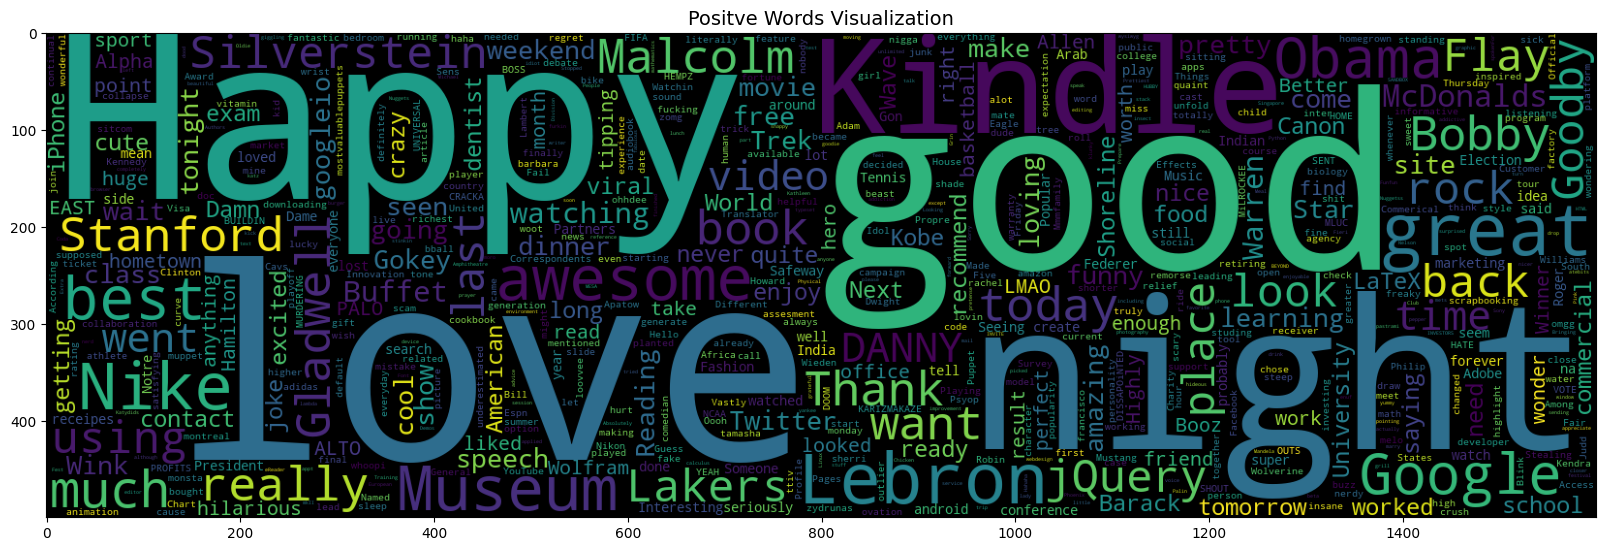

In [63]:
## For Positive Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(dataset[dataset['target']==4]['text'].astype(str)))
plt.title('Positve Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

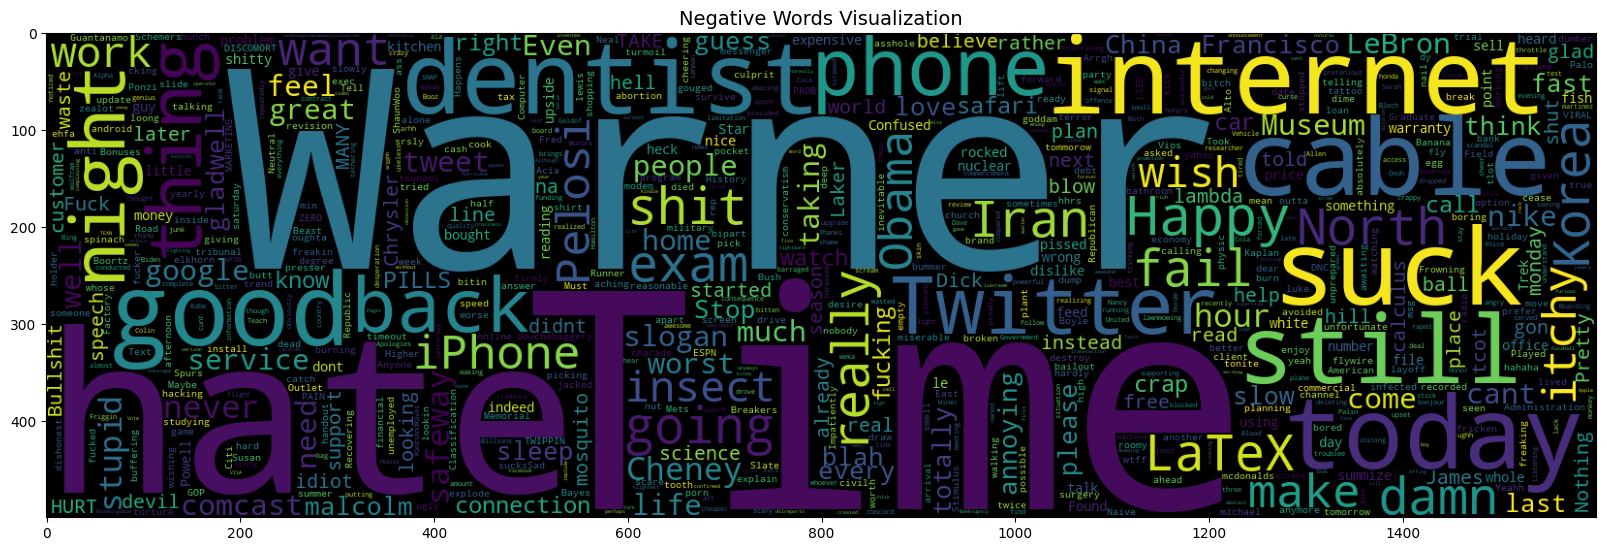

In [64]:
## For Negative Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(dataset[dataset['target']==0]['text'].astype(str)))
plt.title('Negative Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

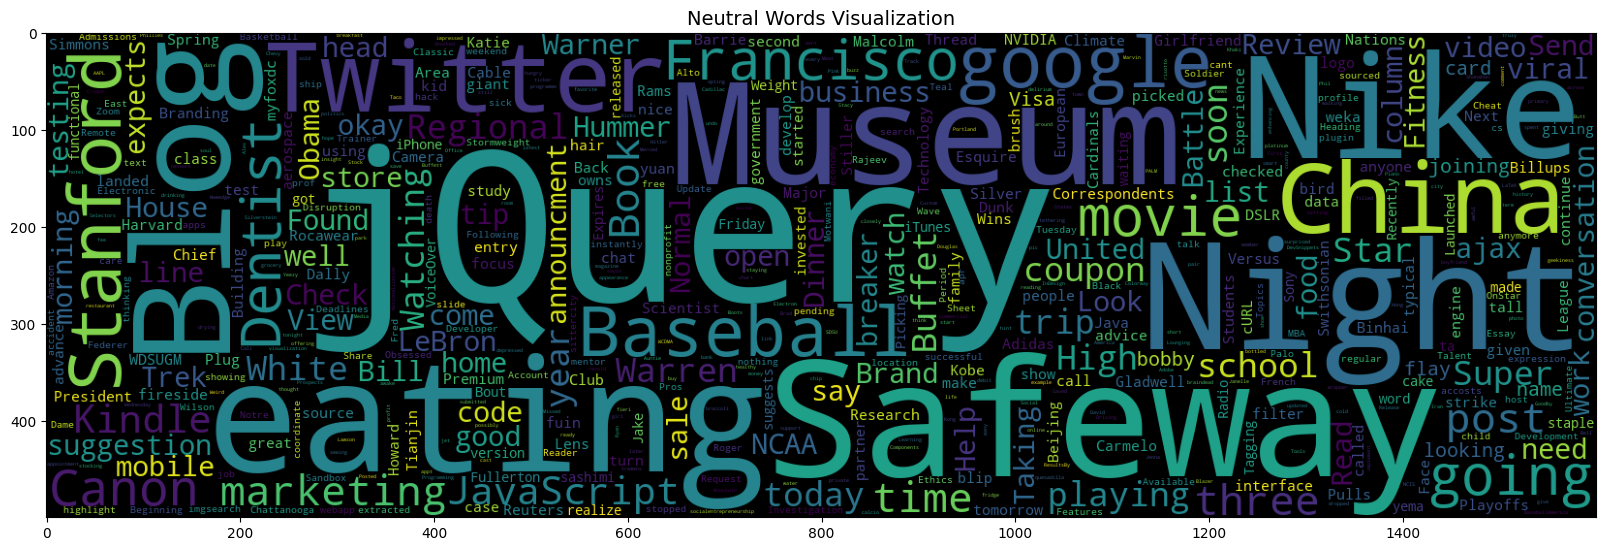

In [66]:
## For Neutral Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(dataset[dataset['target']==2]['text'].astype(str)))
plt.title('Neutral Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

# Vectorization

In [68]:
# artifacts folder path
ARTIFACTS_FOLDER_PATH = os.path.join(os.getcwd(), '..', 'artifacts')
os.makedirs(ARTIFACTS_FOLDER_PATH, exist_ok=True)

* `1. BOW`

In [67]:
# Extracting Features from Cleaned Tweets using BOW 
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_bow = bow_vectorizer.fit_transform(dataset['text'])
X_bow = X_bow.toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [69]:
# dump the bow_vectorizer
joblib.dump(bow_vectorizer, os.path.join(ARTIFACTS_FOLDER_PATH, 'bow_vectorizer.pkl'))

['c:\\Users\\KARIM\\Downloads\\Twitter-sentimental-analysis\\src\\..\\artifacts\\bow_vectorizer.pkl']

`2. TF-IDF`

In [70]:
# Extracting Features from Cleaned Tweets using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(dataset['text'])
X_tfidf = X_tfidf.toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
joblib.dump(tfidf_vectorizer, os.path.join(ARTIFACTS_FOLDER_PATH, 'tfidf_vectorizer.pkl'))

['c:\\Users\\KARIM\\Downloads\\Twitter-sentimental-analysis\\src\\..\\artifacts\\tfidf_vectorizer.pkl']

`3. GloVe`


In [72]:
# Using GloVe
X_glove = np.array([nlp(text).vector for text in tqdm(dataset["text"])])
X_glove

100%|██████████| 498/498 [00:04<00:00, 113.44it/s]


array([[-0.550568  ,  0.1410358 , -0.0646704 , ...,  0.033866  ,
         0.0273496 ,  0.0105966 ],
       [-0.6808767 ,  0.29182148, -0.20641865, ..., -0.16637833,
         0.01048784,  0.3305572 ],
       [-0.766266  , -0.09361979, -0.1116804 , ...,  0.0479892 ,
        -0.0781142 , -0.0077544 ],
       ...,
       [-0.69465667, -0.04289534, -0.20735167, ..., -0.09098934,
        -0.035964  , -0.19876902],
       [-0.577745  ,  0.003495  ,  0.04872834, ...,  0.05882917,
        -0.2888053 ,  0.32526886],
       [-0.70540506,  0.11329388, -0.14466599, ..., -0.13584839,
        -0.09285676,  0.1615859 ]], dtype=float32)

`4. word2vec`

In [ ]:
# Tokenize text data
tokenized_sentences = [text.split() for text in dataset["text"]]

# You can use pretrained models ready for Word2Vec and FastText, But I will train it (it is samll corpus may be not good option)
w2vec_model = Word2Vec(
    sentences=tokenized_sentences, 
    vector_size=300,
    window=5,
    min_count=1,
    sg=1,
    epochs=20,
    workers=4
)

In [74]:
# Save the trained model
w2vec_model.save(os.path.join(ARTIFACTS_FOLDER_PATH, "w2vec_custom.model"))

`5. GloVe Twitter`




In [75]:
# Load pre-trained model
glove_twitter_model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [76]:
def sentence_to_vector_pretrained(sentence):
    words = sentence.lower().split()
    word_vectors = [glove_twitter_model[word] for word in words if word in glove_twitter_model]
    
    if len(word_vectors) == 0:
        return np.zeros(25)  # GloVe Twitter has 25 dimensions

    return np.mean(word_vectors, axis=0)

# Convert all tweets to vectors
X_glove_twitter = np.array([
    sentence_to_vector_pretrained(text) for text in dataset["text"]
])
X_glove_twitter.shape

(498, 25)

* `Split The dataset`


In [77]:
# mapping --> Some Algoritms can't handle non sequential encoding
dict_map = {0: 0, 4: 1, 2: 2}    # 0: Negative (still 0) || 4: Positive > 1 || 2: Neutral (still 2)
dict_rev_map = {v: k for k, v in dict_map.items()}

# Apply that to the dataset
dataset.loc[:, 'target'] = dataset['target'].map(dict_map)
dataset['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [78]:
# Function to be easy in training the model
def prepare_data(method='BOW'):
    if method.lower() == 'bow':
        X = X_bow
    elif method.lower() == 'tfidf':
        X = X_tfidf 
    elif method.lower() == 'word2vec':
        X = X_w2vec_custom
    elif method.lower() == 'glove':
        X = X_glove
    elif method.lower() == 'glove_twitter':
        X = X_glove_twitter
    else:
        raise ValueError("Enter a valid method from ('BOW', 'TFIDF', 'Word2Vec', 'GloVe', 'GloVe_Twitter')")
    
    y = dataset['target']
    
    # Using SMOTE to solve imblanced dataset
    over = SMOTE()
    X_new, y_new = over.fit_resample(X, y)

    # Split Datsets to train and test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, 
                                                        shuffle=True, stratify=y_new, 
                                                        test_size=0.2, random_state=15)
    
    return X_train, X_test, y_train, y_test

In [87]:
def svm_model(method: str):
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(method=method)
   
    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10, 50, 100],
        'gamma': ['scale', 0.1, 0.5, 1, 2],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    
    grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=3, n_jobs=1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best Model
    best_svc = grid_search.best_estimator_
    
    # Accuracy
    y_pred_train = best_svc.predict(X_train)
    y_pred_test = best_svc.predict(X_test)
    
    acc_train = round(100 * accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(100 * accuracy_score(y_test, y_pred_test), 4)
    
    # Additional Metrics
    report = classification_report(y_test, y_pred_test)
    confusion = confusion_matrix(y_test, y_pred_test)
    
    return best_svc, acc_train, acc_test, report, confusion


In [91]:
# Applying SVM model with Bag of Words (BOW)
svc_bow, acc_train_svm_bow, acc_test_svm_bow, report_bow, confusion_bow = svm_model(method='BOW')

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.

In [92]:
# Print results
print(f'Accuracy Score for Training Dataset using BOW with SVM:\t {acc_train_svm_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW with SVM:\t {acc_test_svm_bow} %')
print("\nClassification Report:\n", report_bow)
print("\nConfusion Matrix:\n", confusion_bow)


Accuracy Score for Training Dataset using BOW with SVM:	 97.0183 %
Accuracy Score for Testing Dataset using BOW with SVM:	 73.6364 %

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75        37
           1       0.66      0.73      0.69        37
           2       0.74      0.81      0.77        36

    accuracy                           0.74       110
   macro avg       0.75      0.74      0.74       110
weighted avg       0.75      0.74      0.74       110


Confusion Matrix:
 [[25  8  4]
 [ 4 27  6]
 [ 1  6 29]]


In [108]:
# Applying SVM model with # Using TFIDF with SVM

svc_TFIDF, acc_train_svm_TFIDF, acc_test_svm_TFIDF, report_TFIDF, confusion_TFIDF = svm_model(method='TFIDF')

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.

In [111]:
# Print results
print(f'Accuracy Score for Training Dataset using TFIDF with SVM:\t {acc_train_svm_TFIDF} %')
print(f'Accuracy Score for Testing Dataset using TFIDF with SVM:\t {acc_test_svm_TFIDF} %')
print("\nClassification Report:\n", report_TFIDF)
print("\nConfusion Matrix:\n", confusion_TFIDF)


Accuracy Score for Training Dataset using TFIDF with SVM:	 95.8716 %
Accuracy Score for Testing Dataset using TFIDF with SVM:	 77.2727 %

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78        37
           1       0.67      0.92      0.77        37
           2       0.89      0.67      0.76        36

    accuracy                           0.77       110
   macro avg       0.80      0.77      0.77       110
weighted avg       0.80      0.77      0.77       110


Confusion Matrix:
 [[27  8  2]
 [ 2 34  1]
 [ 3  9 24]]


In [95]:
# Applying SVM model with Glove
svc_Glove, acc_train_svm_Glove, acc_test_svm_Glove, report_Glove, confusion_Glove = svm_model(method='Glove')

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.

In [110]:
# Print results
print(f'Accuracy Score for Training Dataset using Glove with SVM:\t {acc_train_svm_Glove} %')
print(f'Accuracy Score for Testing Dataset using Glove with SVM:\t {acc_test_svm_Glove} %')
print("\nClassification Report:\n", report_Glove)
print("\nConfusion Matrix:\n", confusion_Glove)

Accuracy Score for Training Dataset using Glove with SVM:	 81.8807 %
Accuracy Score for Testing Dataset using Glove with SVM:	 70.9091 %

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81        37
           1       0.63      0.59      0.61        37
           2       0.68      0.75      0.71        36

    accuracy                           0.71       110
   macro avg       0.71      0.71      0.71       110
weighted avg       0.71      0.71      0.71       110


Confusion Matrix:
 [[29  5  3]
 [ 5 22 10]
 [ 1  8 27]]


In [104]:
# Applying SVM model with glove_twitter
svc_glove_twitter, acc_train_svm_glove_twitter, acc_test_svm_glove_twitter, report_glove_twitter, confusion_glove_twitter = svm_model(method='glove_twitter')

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.

In [106]:
# Print results
print(f'Accuracy Score for Training Dataset using glove_twitter with SVM:\t {acc_train_svm_glove_twitter} %')
print(f'Accuracy Score for Testing Dataset using glove_twitter with SVM:\t {acc_test_svm_glove_twitter} %')
print("\nClassification Report:\n", report_glove_twitter)
print("\nConfusion Matrix:\n", confusion_glove_twitter)

Accuracy Score for Training Dataset using glove_twitter with SVM:	 79.8165 %
Accuracy Score for Testing Dataset using glove_twitter with SVM:	 73.6364 %

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79        37
           1       0.69      0.65      0.67        37
           2       0.71      0.81      0.75        36

    accuracy                           0.74       110
   macro avg       0.74      0.74      0.74       110
weighted avg       0.74      0.74      0.74       110


Confusion Matrix:
 [[28  6  3]
 [ 4 24  9]
 [ 2  5 29]]


In [ ]:
# dump model
joblib.dump(svc_glove_twitter, os.path.join(ARTIFACTS_FOLDER_PATH, 'svc_glove_twitter.pkl'))

['c:\\Users\\KARIM\\Downloads\\Twitter-sentimental-analysis\\src\\..\\artifacts\\svc_glove_twitter.pkl']

: 